In [38]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cpf
plt.style.use('default')

To use this example you first need to :
1. Put your grid into the `Grids` folder
2. Run M2R with your grid to create an init file and put the file in the `test_data` folder
3. Use the init and the grid file as input to this notebook below

In [39]:
ds_full = xr.open_dataset('test_data/Antarctic_init_GLORYS_19930115_to_19930531.nc')
ds_grid=xr.open_dataset("Grids/ANT_01.nc")

We select a specific depth layer and time-step

In [40]:
ds = ds_full.isel(s_rho=39, ocean_time=0)
print(ds)

<xarray.Dataset>
Dimensions:     (eta_psi: 567, eta_rho: 568, eta_u: 568, eta_v: 567, s_w: 41, xi_psi: 749, xi_rho: 750, xi_u: 749, xi_v: 750)
Coordinates:
    s_rho       float64 -0.0125
  * s_w         (s_w) float64 -1.0 -0.975 -0.95 -0.925 ... -0.05 -0.025 0.0
    ocean_time  datetime64[ns] NaT
Dimensions without coordinates: eta_psi, eta_rho, eta_u, eta_v, xi_psi, xi_rho, xi_u, xi_v
Data variables: (12/39)
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
    lon_u       (eta_u, xi_u) float64 ...
    lat_u       (eta_u, xi_u) float64 ...
    lon_v       (eta_v, xi_v) float64 ...
    lat_v       (eta_v, xi_v) float64 ...
    ...          ...
    sig12       (eta_rho, xi_rho) float32 ...
    sig22       (eta_rho, xi_rho) float32 ...
    tau_iw      float64 ...
    chu_iw      float64 ...
    t0mk        (eta_rho, xi_rho) float32 ...
    s0mk        (eta_rho, xi_rho) float32 ...
Attributes:
    title:        Initial forcing file (INIT) used fo

Calculate average of u and v at rho points

In [41]:
u_rho = (ds.u[0:-1,:].values+ds.u[1::,:].values)/2.0
v_rho = (ds.v[:,0:-1].values+ds.v[:,1::].values)/2.0

Rotate the u and v vectors to longitude and latitude position
and direction true north and east

In [42]:
angle = ds_grid.angle[0:-1,0:-1].values
print("angle : {}".format(np.shape(angle)))

angle : (567, 749)


In [43]:
u=u_rho
v=v_rho
print("u : {} v: {}".format(np.shape(u), np.shape(v)))

u : (567, 749) v: (567, 749)


In [44]:
u_rotated = u*np.cos(angle)-v*np.sin(angle)
v_rotated = v*np.cos(angle)+u*np.sin(angle)
print("u : {} and v: {}".format(np.shape(u_rotated),
                                np.shape(v_rotated)))


u : (567, 749) and v: (567, 749)


In [45]:
curvilinear_ds = xr.DataArray(
            name="u",
            data=u_rotated,
            coords={'lat': (['y','x'], ds["lat_rho"][0:-1,0:-1].values),
                    'lon': (['y','x'], ds["lon_rho"][0:-1,0:-1].values)},
            dims=["y","x"]
        ).to_dataset()

speed=np.square(u_rotated**2 + v_rotated**2)
curvilinear_ds["v"]=(['y', 'x'],  v_rotated)
curvilinear_ds["speed"]=(['y', 'x'],  speed)
curvilinear_ds["temp"]=(['y', 'x'],  ds.temp[0:-1,0:-1].values)
print(curvilinear_ds)

<xarray.Dataset>
Dimensions:  (x: 749, y: 567)
Coordinates:
    lat      (y, x) float64 -80.37 -80.37 -80.37 -80.37 ... -40.29 -40.29 -40.29
    lon      (y, x) float64 -100.1 -99.97 -99.82 -99.68 ... 9.456 9.603 9.75
Dimensions without coordinates: x, y
Data variables:
    u        (y, x) float64 nan nan nan nan ... 0.05217 0.01726 -0.006432
    v        (y, x) float64 nan nan nan nan ... 0.02749 0.05593 0.1224 0.1765
    speed    (y, x) float64 nan nan nan nan ... 3.422e-05 0.0002335 0.0009739
    temp     (y, x) float32 nan nan nan nan nan ... 12.32 12.61 12.88 12.75


Plot the grid - zoom in to see some details

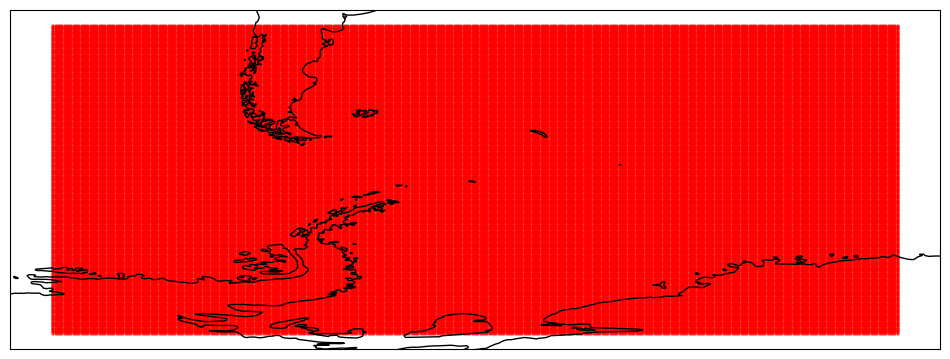

In [46]:
plt.figure(figsize=(12,12))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.scatter(curvilinear_ds["lon"],curvilinear_ds["lat"],c="r",s=0.1)
ax.coastlines()
plt.show()

Plot the streamlines of u and v

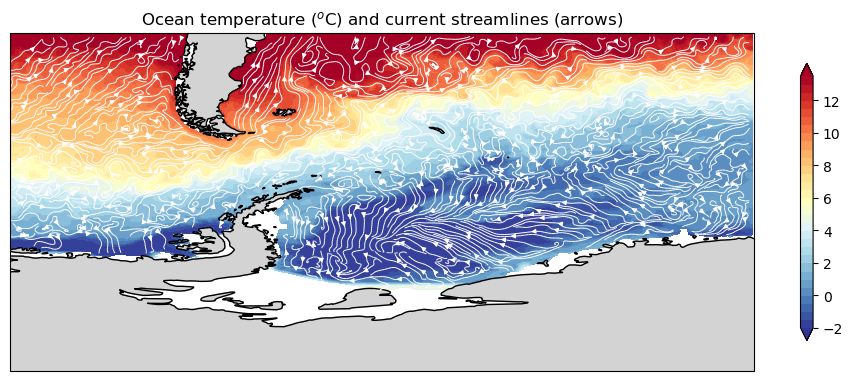

In [47]:
fig = plt.figure(figsize=(12, 12))
crs_latlon = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=crs_latlon)
ax.set_extent([-100, 10. , -90, -40], crs=crs_latlon)
ax.coastlines('50m')
cf = ax.contourf(curvilinear_ds["lon"].values,
             curvilinear_ds["lat"].values,
             curvilinear_ds["temp"].values,
             levels=np.arange(-2,14, 0.5),
             cmap='RdYlBu_r',
             extend='both',
             transform=ccrs.PlateCarree())

ax.add_feature(cpf.LAND, color="lightgrey")
plt.colorbar(cf,ax=ax, shrink=0.3)
plt.title("Ocean temperature ($^{o}$C) and current streamlines (arrows)")
sp = ax.streamplot(curvilinear_ds["lon"].values,
                   curvilinear_ds["lat"].values,
                   curvilinear_ds["u"].values,
                   curvilinear_ds["v"].values,
                   linewidth=0.7    ,
                   arrowsize = 0.7,
                   density=6,
                   color='w',
                   transform=ccrs.PlateCarree())
plt.savefig("Figures/temp_Antarctic.png", dpi=150, bbox_inches = 'tight')

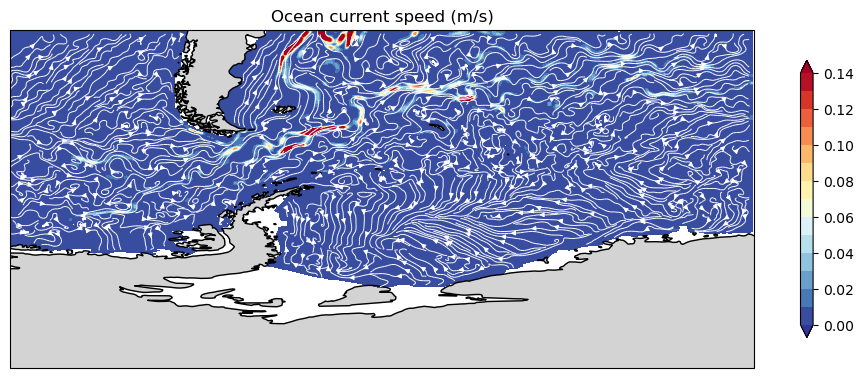

In [48]:
fig = plt.figure(figsize=(12, 12))
crs_latlon = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=crs_latlon)
ax.set_extent([-100, 10. , -90, -40], crs=crs_latlon)
ax.coastlines('50m')

cf = ax.contourf(curvilinear_ds["lon"].values,
                     curvilinear_ds["lat"].values,
                     speed,
                     levels=np.arange(0,0.15, 0.01),
                     cmap='RdYlBu_r',
                     extend='both',
                     transform=ccrs.PlateCarree())

ax.add_feature(cpf.LAND, color="lightgrey")
plt.title("Ocean current speed (m/s)")
sp = ax.streamplot(curvilinear_ds["lon"].values,
                   curvilinear_ds["lat"].values,
                   curvilinear_ds["u"].values,
                   curvilinear_ds["v"].values,
                   linewidth=0.7    ,
                   arrowsize = 0.7,
                   density=6,
                   color='w',
                   transform=ccrs.PlateCarree())
plt.colorbar(cf,ax=ax, shrink=0.3)

Calculate average of uice and vice at rho points

In [49]:
uice_rho = (ds.uice[0:-1,:].values+ds.uice[1::,:].values)/2.0
vice_rho = (ds.vice[:,0:-1].values+ds.vice[:,1::].values)/2.0

Rotate the uice and vice vectors to longitude and latitude position
and direction true north and east

In [50]:
uice=uice_rho
vice=vice_rho
print("u : {} v: {}".format(np.shape(uice), np.shape(vice)))

u : (567, 749) v: (567, 749)


In [51]:
uice_rotated = uice*np.cos(angle)-vice*np.sin(angle)
vice_rotated = vice*np.cos(angle)+uice*np.sin(angle)
print("u : {} and v: {}".format(np.shape(uice_rotated),
                                np.shape(vice_rotated)))

u : (567, 749) and v: (567, 749)


In [52]:
curvilinear_ds = xr.DataArray(
            name="uice",
            data=uice_rotated,
            coords={'lat': (['y','x'], ds["lat_rho"][0:-1,0:-1].values),
                    'lon': (['y','x'], ds["lon_rho"][0:-1,0:-1].values)},
            dims=["y","x"]
        ).to_dataset()

speed_ice=np.square(uice_rotated**2 + vice_rotated**2)
curvilinear_ds["vice"]=(['y', 'x'],  vice_rotated)
curvilinear_ds["speed"]=(['y', 'x'],  speed)
curvilinear_ds["temp"]=(['y', 'x'],  ds.temp[0:-1,0:-1].values)


hice range 0.010054943151772022 to 2.5488648414611816


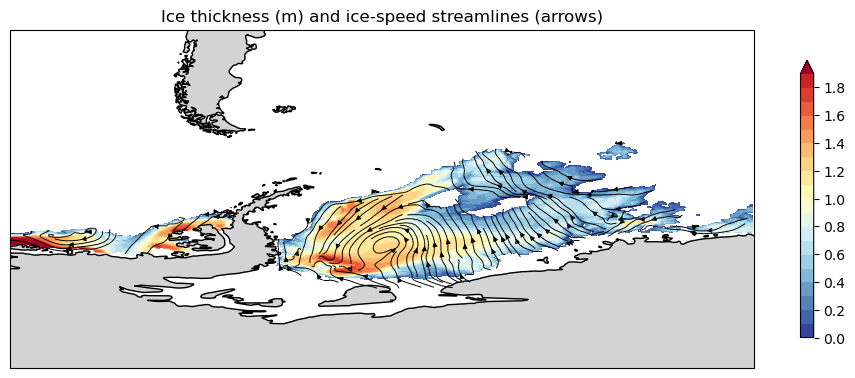

In [53]:
fig = plt.figure(figsize=(12, 12))
crs_latlon = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=crs_latlon)
ax.set_extent([-100, 10. , -90, -40], crs=crs_latlon)
ax.coastlines('50m')

hice=np.where(ds["hice"].values < 0.01, np.nan, ds["hice"].values)
print("hice range {} to {}".format(np.nanmin(hice), np.nanmax(hice)))

cf = ax.contourf(curvilinear_ds["lon"].values,
                     curvilinear_ds["lat"].values,
                     hice[0:-1,0:-1],
                     levels=np.arange(0.0001,2.0, 0.1),
                     cmap='RdYlBu_r',
                     extend='max',
                     vmin=0.0001,vmax=2.0,
                     transform=ccrs.PlateCarree())
plt.colorbar(cf,ax=ax, shrink=0.3)
ax.add_feature(cpf.LAND, color="lightgrey")
plt.title("Ice thickness (m) and ice-speed streamlines (arrows)")
sp = ax.streamplot(curvilinear_ds["lon"].values,
                   curvilinear_ds["lat"].values,
                   curvilinear_ds["uice"].values,
                   curvilinear_ds["vice"].values,
                   linewidth=0.7    ,
                   arrowsize = 0.7,
                   density=4,
                   color='k',
                   transform=ccrs.PlateCarree())
#plt.savefig("Figures/hice_Antarctic.png", dpi=150,  bbox_inches = 'tight')

aice range 0.0001935951877385378 to 98.7181396484375


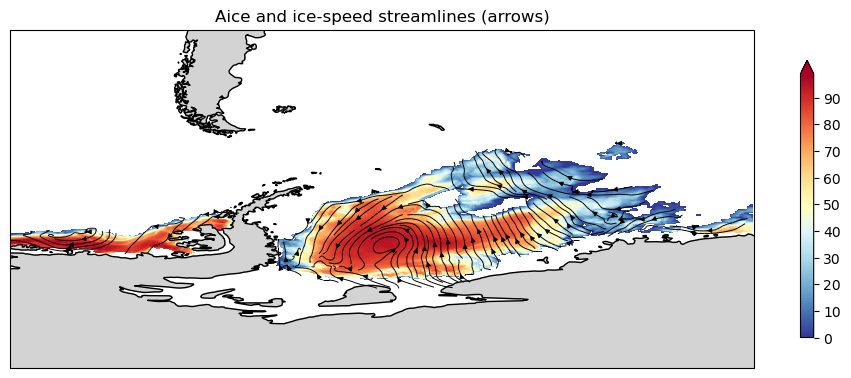

In [54]:
fig = plt.figure(figsize=(12, 12))
crs_latlon = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=crs_latlon)
ax.set_extent([-100, 10. , -90, -40], crs=crs_latlon)
ax.coastlines('50m')

aice=ds["aice"].values
aice = np.where(aice == 0, np.nan, aice)
print("aice range {} to {}".format(np.nanmin(aice), np.nanmax(aice)))

cf = ax.contourf(curvilinear_ds["lon"].values,
                     curvilinear_ds["lat"].values,
                     aice[0:-1,0:-1],
                     levels=np.arange(0,100, 1),
                     cmap='RdYlBu_r',
                     extend='max',
                   #  vmin=0.0001,vmax=2.0,
                     transform=ccrs.PlateCarree())
plt.colorbar(cf,ax=ax, shrink=0.3)

plt.title("Aice and ice-speed streamlines (arrows)")
sp = ax.streamplot(curvilinear_ds["lon"].values,
                   curvilinear_ds["lat"].values,
                   curvilinear_ds["uice"].values,
                   curvilinear_ds["vice"].values,
                   linewidth=0.7    ,
                   arrowsize = 0.7,
                   density=4,
                   color='k',
                   transform=ccrs.PlateCarree())
ax.add_feature(cpf.LAND, color="lightgrey")
plt.savefig("Figures/aice_Antarctic.png", dpi=150,  bbox_inches = 'tight')